In [1]:
%%capture
!apt install -y python3-opengl
!apt install -y ffmpeg
!apt install -y xvfb
!pip3 install pyvirtualdisplay

In [2]:
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

In [3]:
%pip install gymnasium[mujoco]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 13.4 MB/s eta 0:00:00


# Task

We will use the SAC algorithm to train the **walker** environment.

You can implement it yourself or use the Stablebaselines3 version.

Walker environment consists of a structure of legs and the agent's actions can move the joints. The goal is to make the structure able to walk.

You can see more about the actions, observations and rewards [here](https://gymnasium.farama.org/environments/mujoco/walker2d/)

![Walker Image](https://gymnasium.farama.org/_images/walker2d.gif)


In [4]:
from IPython.display import clear_output

In [5]:
%%capture
!apt install -y python3-opengl
!apt install -y ffmpeg
!apt install -y xvfb
!pip3 install pyvirtualdisplay

clear_output()

In [6]:
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

In [7]:
!pip install stable_baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 2.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [8]:
import numpy as np

import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.noise import NormalActionNoise

from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [9]:
## code here
def frames_to_video(frames, fps=24):
    fig = plt.figure(figsize=(frames[0].shape[1] / 100, frames[0].shape[0] / 100), dpi=100)
    ax = plt.axes()
    ax.set_axis_off()

    if len(frames[0].shape) == 2:  # Grayscale image
        im = ax.imshow(frames[0], cmap='gray')
    else:  # Color image
        im = ax.imshow(frames[0])

    def init():
        if len(frames[0].shape) == 2:
            im.set_data(frames[0], cmap='gray')
        else:
            im.set_data(frames[0])
        return im,

    def update(frame):
        if len(frames[frame].shape) == 2:
            im.set_data(frames[frame], cmap='gray')
        else:
            im.set_data(frames[frame])
        return im,

    interval = 1000 / fps
    anim = FuncAnimation(fig, update, frames=len(frames), init_func=init, blit=True, interval=interval)
    plt.close()
    return HTML(anim.to_html5_video())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# Create the environment
make_env = lambda: gym.make('Walker2d-v4')
env = DummyVecEnv([make_env for _ in range(4)])  # adjust accoring to available ram
num_actions = env.action_space.shape[0]

In [11]:
noise_mean = np.array([0.0] * num_actions)
noise_std = np.array([0.1] * num_actions)

In [12]:
# Import necessary libraries
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import CallbackList, EvalCallback, StopTrainingOnRewardThreshold, BaseCallback # Import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# Define a custom callback to store episode rewards
class RewardCallback(BaseCallback):
    """
    Callback for saving episode rewards
    """
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.current_episode_reward = 0

    def _on_step(self) -> bool:
        # Accumulate reward for the current step
        self.current_episode_reward += self.locals.get("rewards")[0]

        # Store the episode reward when an episode ends
        if self.locals.get("dones")[0]:  # Check if the episode is done
            self.episode_rewards.append(self.current_episode_reward)
            self.current_episode_reward = 0 # Reset for the next episode

        return True

# Create the callback
reward_callback = RewardCallback()

In [13]:
model = SAC("MlpPolicy",
            env,
            verbose=1,
            action_noise=NormalActionNoise(noise_mean, noise_std),  # noise for exploration
            learning_rate=5e-4,
            ent_coef='auto',
            )

Using cpu device


In [20]:
clear_output()
# Include the callback in the training process
model.learn(total_timesteps=500000, callback=reward_callback)


Streaming output truncated to the last 5000 lines.
|    n_updates       | 27727    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 488      |
|    fps             | 131      |
|    time_elapsed    | 828      |
|    total_timesteps | 108600   |
| train/             |          |
|    actor_loss      | -114     |
|    critic_loss     | 22       |
|    ent_coef        | 0.0475   |
|    ent_coef_loss   | -1.19    |
|    learning_rate   | 0.0005   |
|    n_updates       | 27972    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 492      |
|    fps             | 130      |
|    time_elapsed    | 836      |
|    total_timesteps | 109348   |
| train/             |          |
|    actor_loss      | -116     |
|    critic_loss     | 23.3     |
|    ent_coef        | 0.0474   |
|    ent_coef_loss   | 3.98     |
|    learning_rate   | 0.0005  

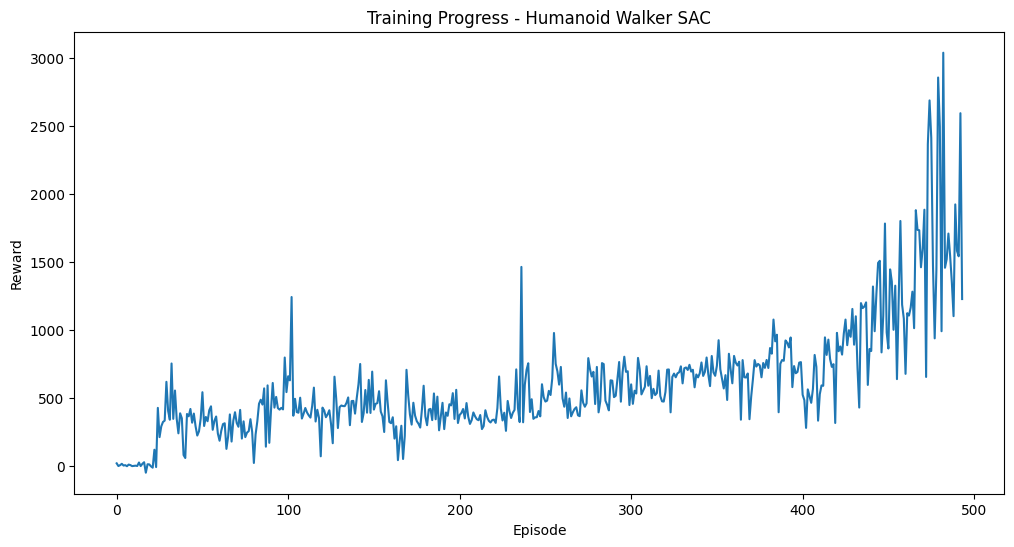

In [21]:
# Plot the training progress using the collected rewards
plt.figure(figsize=(12, 6))
plt.plot(reward_callback.episode_rewards)
plt.title("Training Progress - Humanoid Walker SAC")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

In [22]:
# Evaluate the policy
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward:.2f}")
print(f"Standard deviation of reward: {std_reward:.2f}")

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: 2704.10
Standard deviation of reward: 600.96


In [ ]:
t_env = DummyVecEnv([lambda: gym.make('Walker2d-v4', render_mode="rgb_array")])
state = t_env.reset()
frames = []

while True:
    action, _ = model.predict(state)
    state_next, r, done, info = t_env.step(action)
    frames.append(t_env.render())
    state = state_next
    if done.all():
        break

t_env.close()

In [ ]:
frames_to_video(frames)